# PyPHS Tutorial 4: The Diode clipper

* Define custom components (`Graph` objects)
* Add custom components to the dictionary
* See also
[Falaize, A., & Hélie, T. (2016). Passive Guaranteed Simulation of Analog Audio Circuits: A Port-Hamiltonian Approach. Applied Sciences, 6(10), 273.](https://afalaize.github.io/publis/P1.pdf)


#### Outline
1. Equations for the diode clipper
2. Define a custom component (`Graph` object)
3. Simulation

#### Additionnally
* Add a custom `Graph` to the PyPHS dictionary
* Code generation routines

## 1. Equations for the diode clipper
* A single diode: $i(v) = \mathrm{I_s}\left(\exp\left(\frac{v}{\mathrm{v_{ref}}}\right)-1\right)$
* A diode clipper is made of two diodes with reversed bias
* Constitutive relation: $i(v) = \mathrm{I_s}\left(\exp\left(\frac{v}{\mathrm{v_{p}}}\right)-\exp\left(-\frac{v}{\mathrm{v_{m}}}\right)\right)$

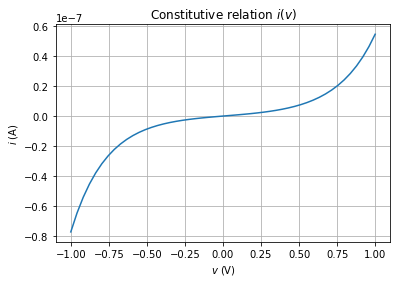

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Is_value, vp_value, vm_value = 1e-9, 25e-2, 23e-2
def diode_clipper_current(v):
    return Is_value*(np.exp(v/vp_value)-np.exp(-v/vm_value))

v = np.linspace(-1, 1)
plt.plot(v, diode_clipper_current(v))
plt.xlabel('$v$ (V)'); plt.ylabel('$i$ (A)'); plt.title('Constitutive relation $i(v)$')
plt.grid('on'); plt.show()

## 2. Define a custom component (`Graph` object)

* 1 storage edge (capacitor)
* 2 dissipation edges (dual-diode and resistor)
<img src="files/figures/clipper.png">

In [2]:
from pyphs import Core, Graph
from pyphs.dictionary import electronics
from pyphs.dictionary.tools import mappars
from sympy import exp

In [3]:
def capa(label, nodes, **args):
    """
    Return a capacitor edge
    """
    return electronics.Capacitor(label, nodes, **args)

def resistor(label, nodes, **args):
    """
    Return a resistor edge
    """
    return electronics.Resistor(label, nodes, **args)

In [4]:
default = {'C':1e-6,      # capacitance
           'R': 1.,       # resistance
           'Is': 1e-09,   # saturation current
           'vm': 25e-3,   # ref voltage (-w)
           'vp': 23e-3    # ref voltage (+w)
          }

In [5]:
class Clipper(Graph):
    
    def __init__(self, label, nodes, **kwargs):
        
        # init parent object
        Graph.__init__(self, label=label)
        
        # Recover nodes labels
        N1, N2 = nodes

        # Default arguments
        args = default.copy()

        # Update arguments
        args.update(kwargs)
        
        # Add a capacitor
        self += capa(label+'C', nodes, C=args['C'])

        # Add a resistor
        self += resistor(label+'R', nodes, R=args['R'])

        # dissipation variable symbol
        w = Core.symbols('w' + label)

        # parameters symbols
        Is, vm, vp = Core.symbols(['Is', 'vm', 'vp'])
        
        # dissipation function (here effort-controlled)
        ze_ctrl = Is*(exp(w/vp) - exp(-w/vm))
        zf_ctrl = 0.

        # format parameters
        dicpars, subs = mappars(self, **args)

        # update dict of subs in core
        self.core.subs.update(subs)
        
        # replace parameters in z by correspondances in 'dicpars'
        ze_ctrl = ze_ctrl.subs(dicpars)
        
        # dual-diode edge data
        data_clipper = {'label': w,                   # edge label
                        'type': 'dissipative',        # edge type
                        'ctrl': 'e',                  # force effort ctrl
                        'link': None,                 # no link
                        'z': {'e_ctrl': ze_ctrl,      # for dissipation edges only
                              'f_ctrl': zf_ctrl},
                       }
        
        # clipper edge
        edge_clipper = (N1, N2, data_clipper)
        
        # all edges
        edges = [edge_clipper]

        # add components to core
        self.core.add_dissipations(w, ze_ctrl)

        # add edges to graph
        self.add_edges_from(edges)
        
    @staticmethod
    def metadata():
        return {'nodes': ('N1', 'N2'),
                'arguments': default}
        

## Usage

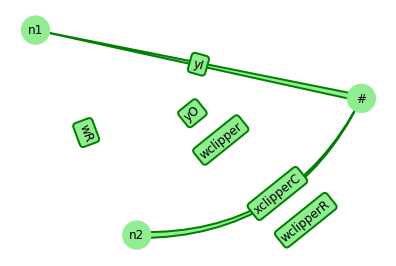

In [6]:
graph = Clipper('clipper', ('n2', '#'))
graph += electronics.Source('I', ('n1', '#'), type='voltage')
graph += electronics.Resistor('R', ('n1', 'n2'), R=0.1)
graph += electronics.Source('O', ('n2', '#'), type='current')

core = graph.to_core()
graph.analysis.plot()

## 5. Simulation

In [7]:
import os
label = core.label
config = {'fs': 48e3,                                # sample rate (Hz)
          'path': os.path.join(os.getcwd(), label),  # folder for output results
         }
simu = core.to_simulation(config=config)             # `Simulation` object.

In [8]:
T = 2.                                               # simulation time (s)
nt = T*config['fs']                                  # number of time steps (int)

### Input $\mathbf u$

In [9]:
from pyphs import signalgenerator
config_isig = {'which': 'sin',         # signal type is noise (amplitude 1)
               'tsig': T,              # signal duration (s)
               'fs': config['fs'],     # signal sample rate (Hz)
               'f0': 200.}             # sin frequency (Hz)
isig = signalgenerator(**config_isig)    # build Python generator

In [10]:
simu.method.u                            # get inputs ordering

[uO, uI]

In [11]:
def u():
    """
    Generator (0, vi) for vi in isig
    """
    for vI_ in isig():
        yield (0., vI_)

In [12]:
simu.init(u=u(), nt=int(nt))         # initialize `Data` object
simu.process()                       # process

/Users/afalaize/Developement/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


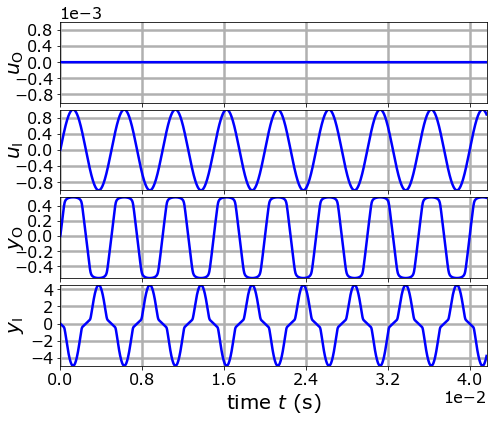

In [13]:
simu.data.plot(('u', 'y'), load={'imax':2000})

In [14]:
vector = 'y'         # in ['x', 'dx', 'dxH', 'w', 'z', 'u', 'y']
index = 0            # index in chosen vector

# wav file path without '.wav' extension
path = os.path.join(simu.config['path'], label+'_out') 
simu.data.wavwrite(vector, index, 
                   path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto4_diode_clipper/clipper/clipper_out
Convert generator to list...
Fade begining and ending...
Write wave file...


In [15]:
vector = 'u'         # in ['x', 'dx', 'dxH', 'w', 'z', 'u', 'y']
index = 1            # index in chosen vector

# wav file path without '.wav' extension
path = os.path.join(simu.config['path'], label+'_in') 
simu.data.wavwrite(vector, index, 
                   path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto4_diode_clipper/clipper/clipper_in
Convert generator to list...
Fade begining and ending...
Write wave file...


## Additionnally: Add a custom component to the dictionary

1. Get the path to the PyPHS dictionary folder
2. Create a new subdictionary (Python package)
3. Create a new component (Python module)
4. Link the new component (Python import)

#### 1. Get the path to the PyPHS dictionary folder

In [16]:
from pyphs import path_to_dictionary

#### 2. Create a new subdictionary (Python package)
In the folder pointed by `path_to_dictionary`:
* create a folder `mydico`,
* create an empty script `mydico/__init__.py`.

#### 3. Create a new component (Python module)
In the folder `mydico`:
* create a script `mydico/mycomponent.py`,
* put your custom component (`Graph` subclass) in that script.

#### 4. Link the new component (Python import)
* Add the following at the end of the `__init__.py` located at `path_to_dictionary`:


    from . import mydico
    __all__ += ['mydico']

* Add the following in `mydico/__init__.py`:


    from .mycomponent import Mycomponent
    __all__ = ['Mycomponent']


## Additionnally: Code generation
Below we give routines to generate
* C++ simulation code
* Faust `.dsp` code
* Juce C++ snippets

### C++ code
Generate a core C++ object:
* `core.h`, `core.cpp`, 
* `parameters.h`, `parameters.h`.

In [17]:
# Define output folder
objlabel = label
cppfolder = os.path.join(os.getcwd(), label, 'src')

In [18]:
# `Core` object to `Method`
method = core.to_method()

In [19]:
method.to_cpp(objlabel=objlabel, path=cppfolder)

### Faust code
Generate a Faust `.dsp` to use in the [Faust compiler](http://faust.grame.fr/onlinecompiler/).

In [20]:
# path to generated .dsp file
dsppath = os.path.join(os.getcwd(), label, label+'.dsp')

In [21]:
# Select inputs: list of constant values and input labels
# Here, we select input as 'uI' and set 'uO' to constant 0
inputs = (0., 'uI')

In [22]:
# Select outputs: list of outputs labels
outputs = ('yO', )

In [23]:
from pyphs import core2faustfx
core2faustfx(core, path=dsppath, inputs=inputs, outputs=outputs)

In [24]:
dsppath

'/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto4_diode_clipper/clipper/clipper.dsp'

### Juce snippets
* Generate a set of pieces of code to be inserted in a Juce template.
* Also generate the c++ core object.

In [25]:
# `Core` object to `Method`
method = core.to_method()

In [26]:
# Define output folder
objlabel = label
jucefolder = os.path.join(os.getcwd(), label, 'juce')

In [27]:
# Here, we select input as 'uI' and output as 'yO'
io = (('uI', ),  ('yO', ))

In [28]:
from pyphs.misc.juce import fx
fx.method2jucefx(method, objlabel=objlabel, path=jucefolder, io=io)